<a href="https://colab.research.google.com/github/OrtegaJulio7/SIS420/blob/main/Primer%20Parcial/1parcial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Primer parcial ( Regresion one vs all)
### Nombre: Ortega Albarado Julio Cesar
### Carrera: Ing. de Sistemas
### Dataset: https://www.kaggle.com/datasets/colewelkins/cardiovascular-disease
### Github:https://github.com/OrtegaJulio7/SIS420/blob/main/Primer%20Parcial/1parcial.ipynb

In [489]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [490]:
# utilizado para la manipulación de directorios y rutas
import os

# Cálculo científico y vectorial para python
import numpy as np

# Libreria para graficos
from matplotlib import pyplot

# le dice a matplotlib que incruste gráficos en el cuaderno
%matplotlib inline

Variables

ID : Identificador único para cada paciente.

edad : Edad del paciente en días.

age_years : Edad del paciente en años (derivada de age).

género : género del paciente. Variable categórica (1: femenino, 2: masculino).

altura : Altura del paciente en centímetros.

peso : Peso del paciente en kilogramos.

ap_hi : Presión arterial sistólica.

ap_lo : Presión arterial diastólica.

Colesterol : Niveles de colesterol. Variable categórica (1: Normal, 2: Por encima de lo normal, 3: Muy por encima de lo normal).

gluc : Niveles de glucosa. Variable categórica (1: Normal, 2: Por encima de lo normal, 3: Muy por encima de lo normal).

smoke : Estado de fumador. Variable binaria (0: no fumador, 1: fumador).

alco : Consumo de alcohol. Variable binaria (0: No consume alcohol, 1: Consume alcohol).

activo : Actividad física. Variable binaria (0: No físicamente activo, 1: Físicamente activo).

cardio : Presencia o ausencia de enfermedad cardiovascular.Variable objetivo. Binaria (0: Ausencia, 1: Presencia).

imc : Índice de masa corporal, derivado de weighty height. Calculado como ( \text{IMC} = \frac{\text{peso (kg)}}{\text{altura (m)}^2} ).

bp_category : Categoría de presión arterial basada en ap_hiy ap_lo. Las categorías incluyen "Normal", "Elevada", "Hipertensión en etapa 1", "Hipertensión en etapa 2" y "Crisis hipertensiva".

bp_category_encoded : Forma codificada bp_categorypara fines de aprendizaje automático.

#Atributos sintéticos de texto, caracteres o booleanos añadidos

TEXTO

a. "Cardiovascular Risk Level":
Un resumen categórico que refleja el riesgo de enfermedad cardiovascular según factores como colesterol, glucosa, presión arterial, tabaquismo, alcohol, y actividad física.

Ejemplo de valores: ["Low", "Moderate", "High", "Very High"]
Criterios:
"Low" si colesterol y glucosa son normales, y no fuma ni bebe.
"Very High" si tiene hipertensión y es fumador.

BOOLEANOS

b. "Hypertension Risk":
Este atributo indica si el paciente tiene riesgo de hipertensión basado en su presión arterial y consumo de tabaco o alcohol.

CARACTER

a. "Lifestyle":
Un atributo que combina varios factores para describir el estilo de vida del paciente (actividad física, consumo de alcohol, tabaquismo).

Ejemplo de valores: ["Healthy", "Moderate", "Unhealthy"]


In [491]:
import pandas as pd
import numpy as np

# Cargar los datos usando Pandas
df = pd.read_csv('/content/drive/MyDrive/datasets/cardio_data_processed.csv')

# Un resumen categórico que refleja el riesgo de enfermedad cardiovascular según factores como colesterol, glucosa, presión arterial, tabaquismo, alcohol, y actividad física.
conditions = [
    (df['cholesterol'] == 1) & (df['bp_category'] == 'Normal') & (df['smoke'] == 0) & (df['alco'] == 0),
    (df['cholesterol'] == 2) | (df['gluc'] == 2) | (df['bp_category'] == 'Elevated'),
    (df['cholesterol'] == 3) | (df['gluc'] == 3) | (df['bp_category'] == 'Hypertension Stage 1'),
    (df['cardio'] == 1) | (df['bp_category'] == 'Hypertensive Crisis')
]
risk_labels = ['Low', 'Moderate', 'High', 'Very High']
df['Cardiovascular_Risk'] = np.select(conditions, risk_labels, default='Moderate')
risk_mapping = {
    'Low': 1,
    'Moderate': 2,
    'High': 3,
    'Very High': 4
}
df['Cardiovascular_Risk'] = df['Cardiovascular_Risk'].map(risk_mapping)

#-Este atributo indica si el paciente tiene riesgo de hipertensión basado en su presión arterial y consumo de tabaco o alcohol.
df['Hypertension_Risk'] = (df['ap_hi'] > 130) | (df['smoke'] == 1) | (df['alco'] == 1)

df['Hypertension_Risk'] = df['Hypertension_Risk'].astype(int)

#Un atributo que combina varios factores para describir el estilo de vida del paciente (actividad física, consumo de alcohol, tabaquismo)
conditions = [
    (df['active'] == 1) & (df['smoke'] == 0) & (df['alco'] == 0),
    (df['active'] == 1) & ((df['smoke'] == 1) | (df['alco'] == 1)),
    (df['active'] == 0) & ((df['smoke'] == 1) | (df['alco'] == 1))
]
lifestyle_labels = ['Healthy', 'Moderate', 'Unhealthy']
df['Lifestyle'] = np.select(conditions, lifestyle_labels, default='Moderate')

lifestyle_mapping = {
    'Healthy': 1,
    'Moderate': 2,
    'Unhealthy': 3
}
df['Lifestyle'] = df['Lifestyle'].map(lifestyle_mapping)

#------------------


In [492]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68205 entries, 0 to 68204
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   68205 non-null  int64  
 1   age                  68205 non-null  int64  
 2   gender               68205 non-null  int64  
 3   height               68205 non-null  int64  
 4   weight               68205 non-null  float64
 5   ap_hi                68205 non-null  int64  
 6   ap_lo                68205 non-null  int64  
 7   cholesterol          68205 non-null  int64  
 8   gluc                 68205 non-null  int64  
 9   smoke                68205 non-null  int64  
 10  alco                 68205 non-null  int64  
 11  active               68205 non-null  int64  
 12  cardio               68205 non-null  int64  
 13  age_years            68205 non-null  int64  
 14  bmi                  68205 non-null  float64
 15  bp_category          68205 non-null 

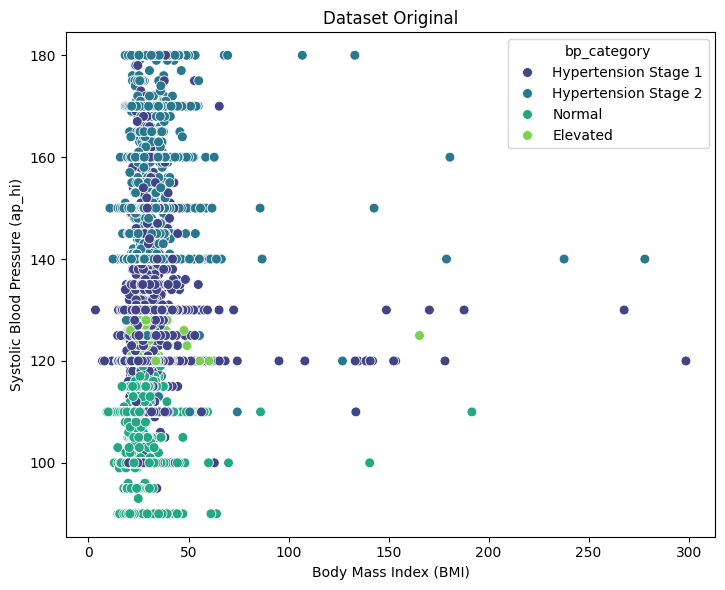

In [493]:
import matplotlib.pyplot as plt
import seaborn as sns

# Asumiendo que df es el dataset original y df_synthetic es el dataset sintético
# Crear el gráfico del dataset original
plt.figure(figsize=(14, 6))

# Gráfico del dataset original
plt.subplot(1, 2, 1)
sns.scatterplot(x='bmi', y='ap_hi', hue='bp_category', data=df, palette='viridis', s=50)
plt.title('Dataset Original')
plt.xlabel('Body Mass Index (BMI)')
plt.ylabel('Systolic Blood Pressure (ap_hi)')
# Mostrar las gráficas
plt.tight_layout()
plt.show()

#1. Perturbación Controlada de Variables Numéricas:

Modifica ligeramente las variables numéricas como age, height, weight, ap_hi, ap_lo, etc., añadiendo o restando valores aleatorios dentro de un rango razonable, sin cambiar drásticamente los valores originales.

In [494]:
import numpy as np

# Crear una copia del dataset
df_synthetic = df.copy()

# Añadir pequeñas perturbaciones a variables numéricas dentro de un rango controlado
df_synthetic['age'] = df['age'] + np.random.randint(-365, 365, size=len(df))  # +/- 1 año
df_synthetic['height'] = df['height'] + np.random.uniform(-5, 5, size=len(df))  # +/- 5 cm
df_synthetic['weight'] = df['weight'] + np.random.uniform(-2, 2, size=len(df))  # +/- 2 kg

# Modificar presión arterial sistólica y diastólica con pequeñas variaciones
df_synthetic['ap_hi'] = df['ap_hi'] + np.random.randint(-5, 5, size=len(df))  # +/- 5 mmHg
df_synthetic['ap_lo'] = df['ap_lo'] + np.random.randint(-5, 5, size=len(df))  # +/- 5 mmHg

# Recalcular el IMC (BMI) basado en los nuevos valores de altura y peso
df_synthetic['bmi'] = df_synthetic['weight'] / (df_synthetic['height'] / 100) ** 2


#2. Ajuste Condicional de Variables Categóricas:

Al modificar variables numéricas, ajusta las variables categóricas relacionadas para que mantengan coherencia (por ejemplo, ajustar la categoría de presión arterial según los valores de ap_hi y ap_lo).

In [495]:
# Recalcular la categoría de presión arterial basada en los valores modificados
def bp_category(ap_hi, ap_lo):
    if ap_hi < 120 and ap_lo < 80:
        return 'Normal'
    elif 120 <= ap_hi < 130 and ap_lo < 80:
        return 'Elevated'
    elif 130 <= ap_hi < 140 or 80 <= ap_lo < 90:
        return 'Hypertension Stage 1'
    elif ap_hi >= 140 or ap_lo >= 90:
        return 'Hypertension Stage 2'
    else:
        return 'Hypertensive Crisis'

df_synthetic['bp_category'] = df_synthetic.apply(lambda row: bp_category(row['ap_hi'], row['ap_lo']), axis=1)


#3. Duplicación y Modificación de Variables Booleanas y Categóricas:

Para variables como smoke, alco, y active, puedes alterar algunos valores con probabilidades controladas para generar variabilidad sin perder consistencia.

In [496]:
# Cambiar estado de fumador, alcohol y actividad física con un 10% de probabilidad
df_synthetic['smoke'] = df['smoke'].apply(lambda x: x if np.random.rand() > 0.1 else 1 - x)
df_synthetic['alco'] = df['alco'].apply(lambda x: x if np.random.rand() > 0.1 else 1 - x)
df_synthetic['active'] = df['active'].apply(lambda x: x if np.random.rand() > 0.1 else 1 - x)


#4. Ajuste de Variables Dependientes:

Asegúrate de recalcular las variables derivadas para mantener la coherencia después de modificar los valores subyacentes.

Recalcular el IMC (bmi) después de ajustar height y weight.

Actualizar el bp_category según los cambios en la presión arterial.

In [497]:
# Recalcular el IMC después de modificaciones en altura y peso
df_synthetic['bmi'] = df_synthetic['weight'] / (df_synthetic['height'] / 100) ** 2

# Recalcular la categoría codificada de presión arterial
bp_category_mapping = {
    'Normal': 0,
    'Elevated': 1,
    'Hypertension Stage 1': 2,
    'Hypertension Stage 2': 3,
    'Hypertensive Crisis': 4
}
df_synthetic['bp_category_encoded'] = df_synthetic['bp_category'].map(bp_category_mapping)


In [498]:
df_synthetic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68205 entries, 0 to 68204
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   68205 non-null  int64  
 1   age                  68205 non-null  int64  
 2   gender               68205 non-null  int64  
 3   height               68205 non-null  float64
 4   weight               68205 non-null  float64
 5   ap_hi                68205 non-null  int64  
 6   ap_lo                68205 non-null  int64  
 7   cholesterol          68205 non-null  int64  
 8   gluc                 68205 non-null  int64  
 9   smoke                68205 non-null  int64  
 10  alco                 68205 non-null  int64  
 11  active               68205 non-null  int64  
 12  cardio               68205 non-null  int64  
 13  age_years            68205 non-null  int64  
 14  bmi                  68205 non-null  float64
 15  bp_category          68205 non-null 

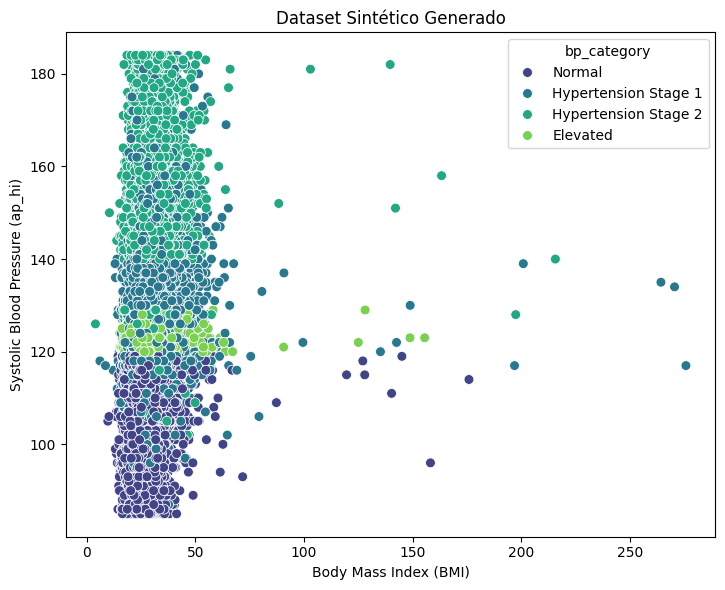

In [499]:
# Gráfico del dataset sintético
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 2)
sns.scatterplot(x='bmi', y='ap_hi', hue='bp_category', data=df_synthetic, palette='viridis', s=50)
plt.title('Dataset Sintético Generado')
plt.xlabel('Body Mass Index (BMI)')
plt.ylabel('Systolic Blood Pressure (ap_hi)')
# Mostrar las gráficas
plt.tight_layout()
plt.show()

#5. Combinación del Dataset Original y Sintético:

Una vez que hayas generado los ejemplos sintéticos, combina el dataset original con los nuevos datos sintéticos.

In [500]:
# 4 etiquetas o clases, de 0 a 3 (normal = 0, hypertension1 = 1, hypertension2 = 2, Elevated: 3)
num_labels = 4
# Concatenar el dataset original y el dataset sintético
df_combined = pd.concat([df, df_synthetic], ignore_index=True)

# Mover la columna 'bp_category' al final
cols = list(df_combined.columns)
cols.append(cols.pop(cols.index('bp_category')))
df_combined = df_combined[cols]

# Eliminar la columna 'bp_category_encoded' por que solo es una copia de la columna bp_category
df_combined = df_combined.drop(columns=['bp_category_encoded'])
# Eliminar la columna 'id'(no tiene relevancia por que es la numeración de las filas)
df_combined = df_combined.drop(columns=['id'])
#datos de entrenamiento 136410
#Separamos 80% de los datos para entrenamiento
X_train = df_combined.iloc[0:109128, 0:16].values
y_train = df_combined.iloc[0:109128:, 17].values
#Separamos 20% de los datos para prueba
X_test = df_combined.iloc[109128:, 0:16].values
y_test = df_combined.iloc[109128:, 17].values

# X=X_test
# y=y_test
X=X_train
y=y_train

# Mapear los valores de la columna 18 según la lógica (normal = 0, hypertension1 = 1, hypertension2 = 2, Elevated: 3)

mapping = {
    'Hypertension Stage 1': 1,
    'Hypertension Stage 2': 2,
    'Normal': 0,
    'Elevated': 3
}
df_combined['bp_category'] = df_combined['bp_category'].map(mapping)

# Reemplazar los valores en la columna de etiquetas según el diccionario de mapeo
y_mapped = np.array([mapping[val] for val in y])
y=y_mapped
y[y == 4] = 0 # asignamos 0 a la clase 4

m = y.size


In [501]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136410 entries, 0 to 136409
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   age                  136410 non-null  int64  
 1   gender               136410 non-null  int64  
 2   height               136410 non-null  float64
 3   weight               136410 non-null  float64
 4   ap_hi                136410 non-null  int64  
 5   ap_lo                136410 non-null  int64  
 6   cholesterol          136410 non-null  int64  
 7   gluc                 136410 non-null  int64  
 8   smoke                136410 non-null  int64  
 9   alco                 136410 non-null  int64  
 10  active               136410 non-null  int64  
 11  cardio               136410 non-null  int64  
 12  age_years            136410 non-null  int64  
 13  bmi                  136410 non-null  float64
 14  Cardiovascular_Risk  136410 non-null  int64  
 15  Hypertension_Risk

In [502]:
#para contar cuantas clases contiene nuestra columna y
class_counts = df_combined["bp_category"].value_counts()

#para contar cuantas caracteristicas tiene nuestro dataset, obviamente con sin contar nuestra y, por eso lo dropeamos, tambien dropeamos la primera columna que no tiene nombre
feactures_counts = df_combined.drop(['bp_category'], axis=1)
feactures_counts = feactures_counts.shape[1]


print(f"la cantidad de caracteristicas es: { feactures_counts}")
print(f'la cantidad de clases es: 4')

#mostramos la cantidad de clases tiene, y en que cantidad
class_counts

la cantidad de caracteristicas es: 17
la cantidad de clases es: 4


,count
bp_category,
1,70033
0,27630
2,26622
3,12125


# Clasificacion one-vs-all

### 1.4 Normalización de caracteristicas

Al visualizar los datos se puede observar que las caracteristicas tienen diferentes magnitudes, por lo cual se debe transformar cada valor en una escala de valores similares, esto con el fin de que el descenso por el gradiente pueda converger mas rapidamente. Se aplica la normalizacion esto debido a que los datos de las X estan a diferentes escalas.

se utiliza para normalizar las características de un conjunto de datos, lo que implica ajustar los valores para que todas las características tengan una media de 0 y una desviación estándar de 1

In [503]:
def featureNormalize(X):
    # Crea una copia del array X para evitar modificar el original.
    X_norm = X.copy()

    # Inicializa arrays de ceros para almacenar los valores de la media (mu) y la desviación estándar (sigma)
    # para cada característica (columna) de X.
    mu = np.zeros(X.shape[1])
    sigma = np.zeros(X.shape[1])

    # Calcula la media (mu) de cada columna de X. `axis=0` indica que el promedio se calcula a lo largo de las filas
    # para cada columna (es decir, por característica).
    mu = np.mean(X, axis=0)

    # Calcula la desviación estándar (sigma) de cada columna de X, también a lo largo de las filas.
    sigma = np.std(X, axis=0)

    # Si alguna desviación estándar es 0 (lo que significa que la característica tiene el mismo valor en todas las filas),
    # se establece en 1 para evitar la división por 0.
    sigma[sigma == 0] = 1

    # Normaliza cada característica utilizando la fórmula:
    # X_norm = (X - mu) / sigma
    # Esto convierte los datos a una escala en la que cada característica tiene una media de 0 y una desviación estándar de 1.
    X_norm = (X - mu) / sigma

    # Retorna los datos normalizados (X_norm), junto con los valores de la media (mu) y la desviación estándar (sigma)
    # que fueron utilizados en la normalización.
    return X_norm, mu, sigma


In [504]:
# llama featureNormalize con los datos cargados
X_norm, mu, sigma = featureNormalize(X)

In [505]:
# # Configurar la matriz adecuadamente, y agregar una columna de unos que corresponde al termino de intercepción.
m, n = X.shape
# # Agrega el termino de intercepción a A
X = X_norm

### 1.5 Creacion de la funcion Sigmoide
También conocida como la función logística, es una función matemática que toma cualquier número real como entrada y devuelve un valor en el rango de 0 a 1. Donde nuestra **Z** es nuestra hipotesis.

Creando la funcion:

In [506]:
def sigmoid(z):
    # Convierte z en un array de numpy, asegurando que puede manejar listas, números o arrays de entrada.
    z = np.array(z)

    # Inicializa g como un array de ceros con la misma forma que z. Esto prepara un array del mismo tamaño para almacenar
    # los resultados de la función sigmoide.
    g = np.zeros(z.shape)

    # Calcula la función sigmoide para cada elemento en z. La función sigmoide está dada por:
    # Esto transforma los valores de z en el rango (0, 1).
    g = 1 / (1 + np.exp(-z))

    # Retorna el valor de g, que es el resultado de aplicar la función sigmoide a z.
    return g


#1.6 Funcion de costo
Aplicando la teoria donde nuestra funcion recibira parametros como Theta, x, y y lamda_, donde lamda_ es nuestro parametro de regularizacion.

Donde la funcion nos devuelve un costo y nuestro gradiente.

In [507]:
def lrCostFunction(theta, X, y, lambda_):
    #creamos una variable m que contiene la longitud de y
    m = y.size

    # convierte las etiquetas a valores enteros si son boleanos
    if y.dtype == bool:
        y = y.astype(int)

    #inicializamos J y grad a 0
    J = 0
    grad = np.zeros(theta.shape)

    #calculamos h haciendo uso de la funcion sigmoid, donde h es un vector de predicciones
    h = sigmoid(X.dot(theta.T))#(X.dot(theta.T))es el producto matricial entre X y theta transpuesto

    # Crea una copia de theta y establece el primer elemento (theta[0]) en 0.
    # Esto se hace porque no se debe aplicar regularización al término de sesgo (bias term).
    temp = theta
    temp[0] = 0

    # Calcula el costo (J) utilizando la función de costo de regresión logística regularizada.
    # La primera parte es la función de costo estándar, y la segunda parte añade la regularización.
    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))

    # Calcula el gradiente (grad), que indica la dirección en la que se deben ajustar los parámetros.
    # Es la derivada del costo con respecto a theta, también incluye el término de regularización.
    grad = (1 / m) * (h - y).dot(X)
    # Añade el término de regularización al gradiente, excepto para theta[0].
    grad = grad + (lambda_ / m) * temp

    return J, grad

### 1.7 Clasificacion One-vs-All
Aqui estariamos usando un ciclo for para iterar sobre cada una de las clases, luego haciendo uso de `optimize.minimize` que es un método de la biblioteca *scipy* que encuentra el mínimo de una función. En este caso, se trata de minimizar la función de costos de regresión logística `(lrCostFunction)`.

Los parámetros iniciales ``(initial_theta)``.

Una tupla que contiene los datos de entrenamiento ``(X)``, las etiquetas ``(y == c)``, y el parámetro de regularización ``(lambda_)``.

``jac=True`` indica que la función de coste devuelve tanto el coste como el gradiente.

El método de optimización ``('CG' significa Gradiente Conjugado).``

El diccionario de opciones ``(options)``  que se establece en 1000 para limitar el número máximo de iteraciones del optimizador.

In [508]:
def oneVsAll(X, y, num_labels, lambda_):
    """
    Entrena múltiples clasificadores de regresión logística usando un esquema
    de "uno contra todos" (One-vs-All) para clasificación multiclase.

    Parameters:
    -----------
    X : ndarray, shape (m, n)
        Matriz de características donde 'm' es el número de ejemplos y 'n' es el número
        de características.
    y : ndarray, shape (m,)
        Vector de etiquetas de salida donde cada valor corresponde a una clase (0, 1, 2, ..., num_labels-1).
    num_labels : int
        Número total de clases o etiquetas posibles (por ejemplo, 10 para la clasificación de dígitos 0-9).
    lambda_ : float
        Parámetro de regularización que controla el overfitting.

    Returns:
    --------
    all_theta : ndarray, shape (num_labels, n + 1)
        Matriz donde cada fila contiene los parámetros entrenados para un clasificador
        de regresión logística correspondiente a cada clase (One-vs-All).
    """

    # algunas variables utiles
    m, n = X.shape  # 'm' es el número de ejemplos, 'n' es el número de características

    # Inicializa la matriz de todos los parámetros theta (all_theta).
    # Cada fila de 'all_theta' contendrá los parámetros para un clasificador.
    # La matriz tiene dimensión (num_labels, n+1) porque se agrega una columna para el término de sesgo.
    all_theta = np.zeros((num_labels, n + 1))

    # Agrega unos a la matriz X
    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    #Entrena un clasificador de regresión logística para cada clase.
    for c in np.arange(num_labels):
       # Inicializa el vector de parámetros 'theta' para la clase actual con ceros.
        initial_theta = np.zeros(n + 1)
        # Establece las opciones del optimizador. 'maxiter' es el número máximo de iteraciones
        # que el optimizador usará para encontrar los parámetros óptimos
        options = {'maxiter': 50}
        # 7. Usa el optimizador 'minimize' para minimizar la función de costo de regresión logística
        res = optimize.minimize(lrCostFunction,
                                initial_theta,
                                (X, (y == c), lambda_),
                                jac=True,
                                method='CG',
                                options=options)

        # Almacena los parámetros óptimos encontrados (res.x) en la fila correspondiente de all_theta.
        all_theta[c] = res.x
         #  Retorna la matriz all_theta con todos los clasificadores entrenados.
    return all_theta

Inicializamos nuestra lambda con valor de *0.1*, usamos la funcion de `oneVsAll` donde pasamos los parametros de *X*, *num_labels* que seria la cantidad de clases que tenemos, y nuestro *lanbda* para asi obtener nuestros Thetas para cada clase.

In [509]:
#defimos el valor de lambda
lambda_ = 0.1 #Este parámetro controla el grado de regularización durante el entrenamiento del modelo de regresión logística
all_theta = oneVsAll(X, y, num_labels, lambda_)
print(all_theta.shape)

(4, 17)


In [510]:
print(all_theta)

[[-5.61037088e+00  9.92351644e-02 -1.33511140e-02  7.19089301e-02
  -6.39879766e-02 -4.48516564e+00 -2.31745761e+00  2.43417660e-03
  -1.11196989e-02  3.56268635e-01  2.88765845e-01 -1.12008492e-01
   4.94365653e-02 -8.49447610e-02  5.13711976e-02 -3.06495636e-01
  -6.05191701e-01]
 [ 1.19752939e-01 -1.24905175e-01  5.83428800e-02  4.98323633e-02
   3.57421905e-02 -1.27687991e-01  2.23410478e-01  1.40124667e-01
   4.95180699e-02  1.79616803e-01  7.17875318e-02  1.59697750e-02
  -1.40839106e-01  2.15587428e-01  2.78747895e-02  8.27877892e-01
  -8.13838965e-01]
 [-3.10696423e+00 -3.43764679e-03  1.69787000e-04  2.02263304e-02
  -6.10429886e-02  7.09221825e-01  2.23322223e+00 -3.16801450e-02
   1.65180340e-02 -2.20904547e-01 -1.39249599e-01  1.76355515e-02
  -1.01357915e-02 -2.26458977e-02 -2.12051133e-03  6.75512435e-04
   9.04538743e-01]
 [-3.51245062e+00  1.93728979e-02  9.46737323e-02  1.10694247e-01
  -5.30315280e-02  1.45323090e+00 -1.95800110e+00 -1.03778446e-01
   6.27368854e-03  

#### 1.7.1 Prediccion One-vs-all
Aqui creamos solo la funcion, donde mandamos los parametros de `all_theta` y la `X` que en este caso puede ser las X de prueba, pero antes deben de estar normalizadas.

In [511]:
def predictOneVsAll(all_theta, X):
    #Predice la clase para cada ejemplo en la matriz X utilizando el modelo
    #entrenado con el enfoque One-vs-All.
    m = X.shape[0];
    num_labels = all_theta.shape[0]

    p = np.zeros(m)

    # añadimos unos a la matriz de X
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    #np.argmax(..., axis=1) selecciona el índice de la clase con la probabilidad más alta para cada ejemplo.
    p = np.argmax(sigmoid(X.dot(all_theta.T)), axis = 1)

    return p

In [512]:
print(X.shape)
pred = predictOneVsAll(all_theta, X)
print('Precision del conjuto de entrenamiento: {:.2f}%'.format(np.mean(pred == y) * 100))


(109128, 16)
Precision del conjuto de entrenamiento: 78.66%
